In [1]:
import pickle
import pandas as pd

# Standard Library Imports
import os, sys, time, math, asyncio, traceback, pickle, importlib, json, requests
from xml.etree import ElementTree as ET
from typing import Dict, Optional
from io import StringIO
from imblearn.metrics import specificity_score
from sentence_transformers import SentenceTransformer
from sklearn.metrics import precision_score, recall_score, cohen_kappa_score, f1_score
# Third-Party Imports
import openai
from openai.error import (
    RateLimitError, AuthenticationError, APIError,
    APIConnectionError, OpenAIError, InvalidRequestError, Timeout
)
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from passlib.hash import bcrypt
import random
# Chainlit Imports
import chainlit as cl
from chainlit.context import ChainlitContextException
import torch
# Llama Index Imports
from llama_index.core.llms import ChatMessage

# Custom Module Imports
import data_gen1, utility

# Reload Custom Modules if Previously Imported
importlib.reload(data_gen1)
importlib.reload(utility)
import utility_semantic_search
from datetime import datetime
from dotenv import load_dotenv
import os


/home/abhishekh/anaconda3/envs/ttd2/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


2025-06-15 15:31:24 - Chainlit data layer initialized
2025-06-15 15:31:25 - Loaded .env file


In [2]:
with open("/home/abhishekh/semantic_simulation_dictionary.pkl", 'rb') as file:
        dct_result = pickle.load(file)

In [68]:
# dct_result

In [3]:
similarity_score_method = ["snowflakes_cutoff", "snowflakes", "OpenAI_cutoff",  "None",  "OpenAI"]
llm_model_for_element_selection_list = ["OpenAI",  "OpenAI", "OpenAI", "OpenAI",  "OpenAI"]

In [70]:
complete_data = pd.read_excel("/home/abhishekh/BioChirp/semantic simulation result.xlsx")
complete_data = complete_data.drop_duplicates()

In [71]:
complete_data

,term,Belong,member,key_word,Pubmed Article Count
0,G-Protein-Coupled Receptor,True,ADRB1,G-Protein-Coupled Receptor AND ADRB1,380
1,G-Protein-Coupled Receptor,True,ADRB2,G-Protein-Coupled Receptor AND ADRB2,796
2,G-Protein-Coupled Receptor,True,ADRA1A,G-Protein-Coupled Receptor AND ADRA1A,389
3,G-Protein-Coupled Receptor,True,ADRA1B,G-Protein-Coupled Receptor AND ADRA1B,275
4,G-Protein-Coupled Receptor,True,ADRA2A,G-Protein-Coupled Receptor AND ADRA2A,519
...,...,...,...,...,...
2424,Immunosuppressant,False,Sildenafil,Immunosuppressant AND Sildenafil,122
2425,Immunosuppressant,False,Tadalafil,Immunosuppressant AND Tadalafil,24
2426,Immunosuppressant,False,Finasteride,Immunosuppressant AND Finasteride,29
2427,Immunosuppressant,False,Dutasteride,Immunosuppressant AND Dutasteride,5


In [5]:
iteration = 5

In [6]:
full_df = pd.DataFrame(columns = ["member", "predicted label", "actual label", "iteration"])

metric_df = pd.DataFrame(columns = ["precision", "recall", "f1",  "kappa", "element scanned"])

for term in set(complete_data["term"]):
    for similarity_score, llm_model_for_element_selection in zip(similarity_score_method, llm_model_for_element_selection_list):

        for i in range(iteration):

            lst_predicted = list()
            lst_predicted_label = list()


            lst_predicted.extend(dct_result[term][(similarity_score, llm_model_for_element_selection)]["result"][i]['positive predicted'])
            lst_predicted_label.extend([1]*len(dct_result[term][(similarity_score, llm_model_for_element_selection)]["result"][i]['positive predicted']))
            lst_predicted.extend(dct_result[term][(similarity_score, llm_model_for_element_selection)]["result"][i]['negative predicted'])
            lst_predicted_label.extend([0]*len(dct_result[term][(similarity_score, llm_model_for_element_selection)]["result"][i]['negative predicted']))

            pred_df = pd.DataFrame(columns = ["term", "predicted label"])
            pred_df["member"] = lst_predicted
            pred_df["predicted label"] = lst_predicted_label
            pred_df["iteration"] = i

            lst_actual = list()
            lst_actual_label = list()

            lst_actual.extend(dct_result[term][(similarity_score, llm_model_for_element_selection)]["result"][i]["positive actual"])
            lst_actual_label.extend([1]*len(dct_result[term][(similarity_score, llm_model_for_element_selection)]["result"][i]["positive actual"]))
            lst_actual.extend(dct_result[term][(similarity_score, llm_model_for_element_selection)]["result"][i]["negative actual"])
            lst_actual_label.extend([0]*len(dct_result[term][(similarity_score, llm_model_for_element_selection)]["result"][i]["negative actual"]))


            actual_df = pd.DataFrame(columns = ["term", "actual label"])
            actual_df["member"] = lst_actual
            actual_df["actual label"] = lst_actual_label
            actual_df["iteration"] = i

            tmp_df = pd.merge(pred_df, actual_df)
            tmp_df["term"] = term
            tmp_df["llm_model_for_element_selection"] = llm_model_for_element_selection
            tmp_df["similarity_score"] = similarity_score
            tmp_df["element_scanned"] = dct_result[term][(similarity_score, llm_model_for_element_selection)]["result"][i]["element_scanned"]
            tmp_df["time_consumed"] = pd.to_timedelta(dct_result[term][(similarity_score, llm_model_for_element_selection)]["result"][i]["time_consumed"]).total_seconds()
            metric_df.loc[i, "precision"] = precision_score(tmp_df["actual label"], tmp_df["predicted label"])
            metric_df.loc[i, "recall"] = recall_score(tmp_df["actual label"], tmp_df["predicted label"])
            metric_df.loc[i, "f1"] = f1_score(tmp_df["actual label"], tmp_df["predicted label"])
            metric_df.loc[i, "kappa"] = cohen_kappa_score(tmp_df["actual label"], tmp_df["predicted label"])
            metric_df.loc[i, "iteration"] = i
            metric_df.loc[i, "element scanned"] = dct_result[term][(similarity_score, llm_model_for_element_selection)]["result"][i]['element_scanned']
            metric_df.loc[i, "term"] = term
            metric_df.loc[i, "similarity_score"] = similarity_score
            metric_df.loc[i, "llm_model_for_element_selection"] = llm_model_for_element_selection
            
            full_df = pd.concat([full_df, tmp_df])


/home/abhishekh/anaconda3/envs/ttd2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/abhishekh/anaconda3/envs/ttd2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/abhishekh/anaconda3/envs/ttd2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

In [7]:
# full_df

In [72]:
complete_data = full_df.drop_duplicates(subset = ["term", "member"])
complete_data

,member,predicted label,actual label,iteration,term,llm_model_for_element_selection,similarity_score,element_scanned,time_consumed
0,Pulmonary Stenosis,1,1,0,cardiovascular,OpenAI,snowflakes_cutoff,143.0,3.100213
1,Aortic Dissection,1,1,0,cardiovascular,OpenAI,snowflakes_cutoff,143.0,3.100213
2,Chronic kidney disease,1,0,0,cardiovascular,OpenAI,snowflakes_cutoff,143.0,3.100213
3,Pulmonary Hypertension,1,1,0,cardiovascular,OpenAI,snowflakes_cutoff,143.0,3.100213
4,Ventricular Septal Defect,1,1,0,cardiovascular,OpenAI,snowflakes_cutoff,143.0,3.100213
...,...,...,...,...,...,...,...,...,...
244,Klinefelter syndrome,0,0,0,cancer,OpenAI,snowflakes_cutoff,213.0,6.210236
245,Hemifacial microsomia,0,0,0,cancer,OpenAI,snowflakes_cutoff,213.0,6.210236
246,Atrial fibrillation,0,0,0,cancer,OpenAI,snowflakes_cutoff,213.0,6.210236
247,Tularemia,0,0,0,cancer,OpenAI,snowflakes_cutoff,213.0,6.210236


In [9]:
complete_data["key_word"] = complete_data["term"] + " AND " + complete_data["member"]
complete_data

/tmp/ipykernel_3057716/2266018919.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complete_data["key_word"] = complete_data["term"] + " AND " + complete_data["member"]


,member,predicted label,actual label,iteration,term,llm_model_for_element_selection,similarity_score,element_scanned,time_consumed,key_word
0,Pulmonary Stenosis,1,1,0,cardiovascular,OpenAI,snowflakes_cutoff,143.0,3.100213,cardiovascular AND Pulmonary Stenosis
1,Aortic Dissection,1,1,0,cardiovascular,OpenAI,snowflakes_cutoff,143.0,3.100213,cardiovascular AND Aortic Dissection
2,Chronic kidney disease,1,0,0,cardiovascular,OpenAI,snowflakes_cutoff,143.0,3.100213,cardiovascular AND Chronic kidney disease
3,Pulmonary Hypertension,1,1,0,cardiovascular,OpenAI,snowflakes_cutoff,143.0,3.100213,cardiovascular AND Pulmonary Hypertension
4,Ventricular Septal Defect,1,1,0,cardiovascular,OpenAI,snowflakes_cutoff,143.0,3.100213,cardiovascular AND Ventricular Septal Defect
...,...,...,...,...,...,...,...,...,...,...
244,Klinefelter syndrome,0,0,0,cancer,OpenAI,snowflakes_cutoff,213.0,6.210236,cancer AND Klinefelter syndrome
245,Hemifacial microsomia,0,0,0,cancer,OpenAI,snowflakes_cutoff,213.0,6.210236,cancer AND Hemifacial microsomia
246,Atrial fibrillation,0,0,0,cancer,OpenAI,snowflakes_cutoff,213.0,6.210236,cancer AND Atrial fibrillation
247,Tularemia,0,0,0,cancer,OpenAI,snowflakes_cutoff,213.0,6.210236,cancer AND Tularemia


In [10]:
article_counts = utility.fetch_article_counts_with_queue(list(complete_data['key_word'] ), max_workers=1)  # You can adjust max_workers
article_counts

{'cardiovascular AND Pulmonary Stenosis': 14465,
 'cardiovascular AND Aortic Dissection': 21961,
 'cardiovascular AND Chronic kidney disease': 47122,
 'cardiovascular AND Pulmonary Hypertension': 36887,
 'cardiovascular AND Ventricular Septal Defect': 14036,
 'cardiovascular AND Ventricular Fibrillation': 23320,
 'cardiovascular AND Congenital Heart Disease': 94988,
 'cardiovascular AND Kawasaki disease': 4093,
 'cardiovascular AND Familial Hypercholesterolemia': 4769,
 'cardiovascular AND Arrhythmia': 146596,
 'cardiovascular AND Pericarditis': 6000,
 'cardiovascular AND Cardiac Sarcoidosis': 1807,
 'cardiovascular AND Pulmonary Embolism': 19502,
 'cardiovascular AND Rheumatic Heart Disease': 8129,
 'cardiovascular AND Aortic Stenosis': 48929,
 'cardiovascular AND Ebstein’s Anomaly': 1710,
 'cardiovascular AND Aortic Aneurysm': 47832,
 'cardiovascular AND Dilated Cardiomyopathy': 14802,
 'cardiovascular AND Stroke': 154762,
 'cardiovascular AND Tetralogy of Fallot': 7619,
 'cardiovasc

In [11]:
# article_counts

In [12]:
complete_data = pd.merge(complete_data, pd.DataFrame(list(article_counts.items()), columns=['key_word', 'Pubmed Article Count']))

In [13]:
complete_data

,member,predicted label,actual label,iteration,term,llm_model_for_element_selection,similarity_score,element_scanned,time_consumed,key_word,Pubmed Article Count
0,Pulmonary Stenosis,1,1,0,cardiovascular,OpenAI,snowflakes_cutoff,143.0,3.100213,cardiovascular AND Pulmonary Stenosis,14465
1,Aortic Dissection,1,1,0,cardiovascular,OpenAI,snowflakes_cutoff,143.0,3.100213,cardiovascular AND Aortic Dissection,21961
2,Chronic kidney disease,1,0,0,cardiovascular,OpenAI,snowflakes_cutoff,143.0,3.100213,cardiovascular AND Chronic kidney disease,47122
3,Pulmonary Hypertension,1,1,0,cardiovascular,OpenAI,snowflakes_cutoff,143.0,3.100213,cardiovascular AND Pulmonary Hypertension,36887
4,Ventricular Septal Defect,1,1,0,cardiovascular,OpenAI,snowflakes_cutoff,143.0,3.100213,cardiovascular AND Ventricular Septal Defect,14036
...,...,...,...,...,...,...,...,...,...,...,...
2475,Klinefelter syndrome,0,0,0,cancer,OpenAI,snowflakes_cutoff,213.0,6.210236,cancer AND Klinefelter syndrome,659
2476,Hemifacial microsomia,0,0,0,cancer,OpenAI,snowflakes_cutoff,213.0,6.210236,cancer AND Hemifacial microsomia,214
2477,Atrial fibrillation,0,0,0,cancer,OpenAI,snowflakes_cutoff,213.0,6.210236,cancer AND Atrial fibrillation,4290
2478,Tularemia,0,0,0,cancer,OpenAI,snowflakes_cutoff,213.0,6.210236,cancer AND Tularemia,93


In [14]:
# complete_data

In [15]:
complete_data_with_citation = pd.merge(full_df, complete_data[["term", "member", "Pubmed Article Count"]], on = ["term", "member"], how = "left")
complete_data_with_citation

,member,predicted label,actual label,iteration,term,llm_model_for_element_selection,similarity_score,element_scanned,time_consumed,Pubmed Article Count
0,Pulmonary Stenosis,1,1,0,cardiovascular,OpenAI,snowflakes_cutoff,143.0,3.100213,14465
1,Aortic Dissection,1,1,0,cardiovascular,OpenAI,snowflakes_cutoff,143.0,3.100213,21961
2,Chronic kidney disease,1,0,0,cardiovascular,OpenAI,snowflakes_cutoff,143.0,3.100213,47122
3,Pulmonary Hypertension,1,1,0,cardiovascular,OpenAI,snowflakes_cutoff,143.0,3.100213,36887
4,Ventricular Septal Defect,1,1,0,cardiovascular,OpenAI,snowflakes_cutoff,143.0,3.100213,14036
...,...,...,...,...,...,...,...,...,...,...
61995,Klinefelter syndrome,0,0,4,cancer,OpenAI,OpenAI,72.0,14.110164,659
61996,Hemifacial microsomia,0,0,4,cancer,OpenAI,OpenAI,72.0,14.110164,214
61997,Atrial fibrillation,0,0,4,cancer,OpenAI,OpenAI,72.0,14.110164,4290
61998,Tularemia,0,0,4,cancer,OpenAI,OpenAI,72.0,14.110164,93


In [44]:
def custom_figure_axis(ax, fontsize=10, show_ticks = True, rotation=90):
    
        
    """
    Customize the appearance of matplotlib axis for a figure.
    
    Parameters:
        ax (matplotlib.axes._subplots.AxesSubplot): The axis to be customized.
        fontsize (int, optional): Font size for axis labels and ticks. Default is 10.
        show_ticks (bool, optional): Whether to display ticks and labels. Default is True.
    
    Returns:
        matplotlib.axes._subplots.AxesSubplot: The customized axis.
    """
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['top'].set_color('white')
    ax.spines['right'].set_color('white')
    ax.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(0.2)
    ax.spines['left'].set_linewidth(0.2)
    ax.tick_params(axis='x', labelsize=fontsize, rotation=rotation)
    ax.tick_params(axis='y', labelsize=fontsize)
    ax.tick_params(axis='both', which='both', width=0.5)
    ax.xaxis.label.set_fontsize(fontsize)
    ax.yaxis.label.set_fontsize(fontsize)
    
    if show_ticks==False:
        ax.set_xlabel(None)
        ax.set_ylabel(None)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        
    return ax


In [57]:
complete_data_with_citation.loc[(complete_data_with_citation['similarity_score'] == 'snowflakes_cutoff') & (complete_data_with_citation['llm_model_for_element_selection'] == 'OpenAI'), 'category'] = 'OSMS_SC'
complete_data_with_citation.loc[(complete_data_with_citation['similarity_score'] == 'None') & (complete_data_with_citation['llm_model_for_element_selection'] == 'OpenAI'), 'category'] = 'OSMS'
complete_data_with_citation.loc[(complete_data_with_citation['similarity_score'] == 'OpenAI') & (complete_data_with_citation['llm_model_for_element_selection'] == 'OpenAI'), 'category'] = 'SBS (OpenAI)'
complete_data_with_citation.loc[(complete_data_with_citation['similarity_score'] == 'OpenAI_cutoff') & (complete_data_with_citation['llm_model_for_element_selection'] == 'OpenAI'), 'category'] = 'OSMS_OC'
complete_data_with_citation.loc[(complete_data_with_citation['similarity_score'] == 'snowflakes') & (complete_data_with_citation['llm_model_for_element_selection'] == 'OpenAI'), 'category'] = 'SBS (Snowflakes)'


In [18]:
# Define a function to determine the label
def get_label(row):
    if row['predicted label'] == 1 and row['actual label'] == 1:
        return 'TP'
    elif row['predicted label'] == 1 and row['actual label'] == 0:
        return 'FP'
    elif row['predicted label'] == 0 and row['actual label'] == 1:
        return 'FN'
    elif row['predicted label'] == 0 and row['actual label'] == 0:
        return 'TN'

# Apply the function to each row
complete_data_with_citation['label'] = complete_data_with_citation.apply(get_label, axis=1)

/tmp/ipykernel_3057716/546520328.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')


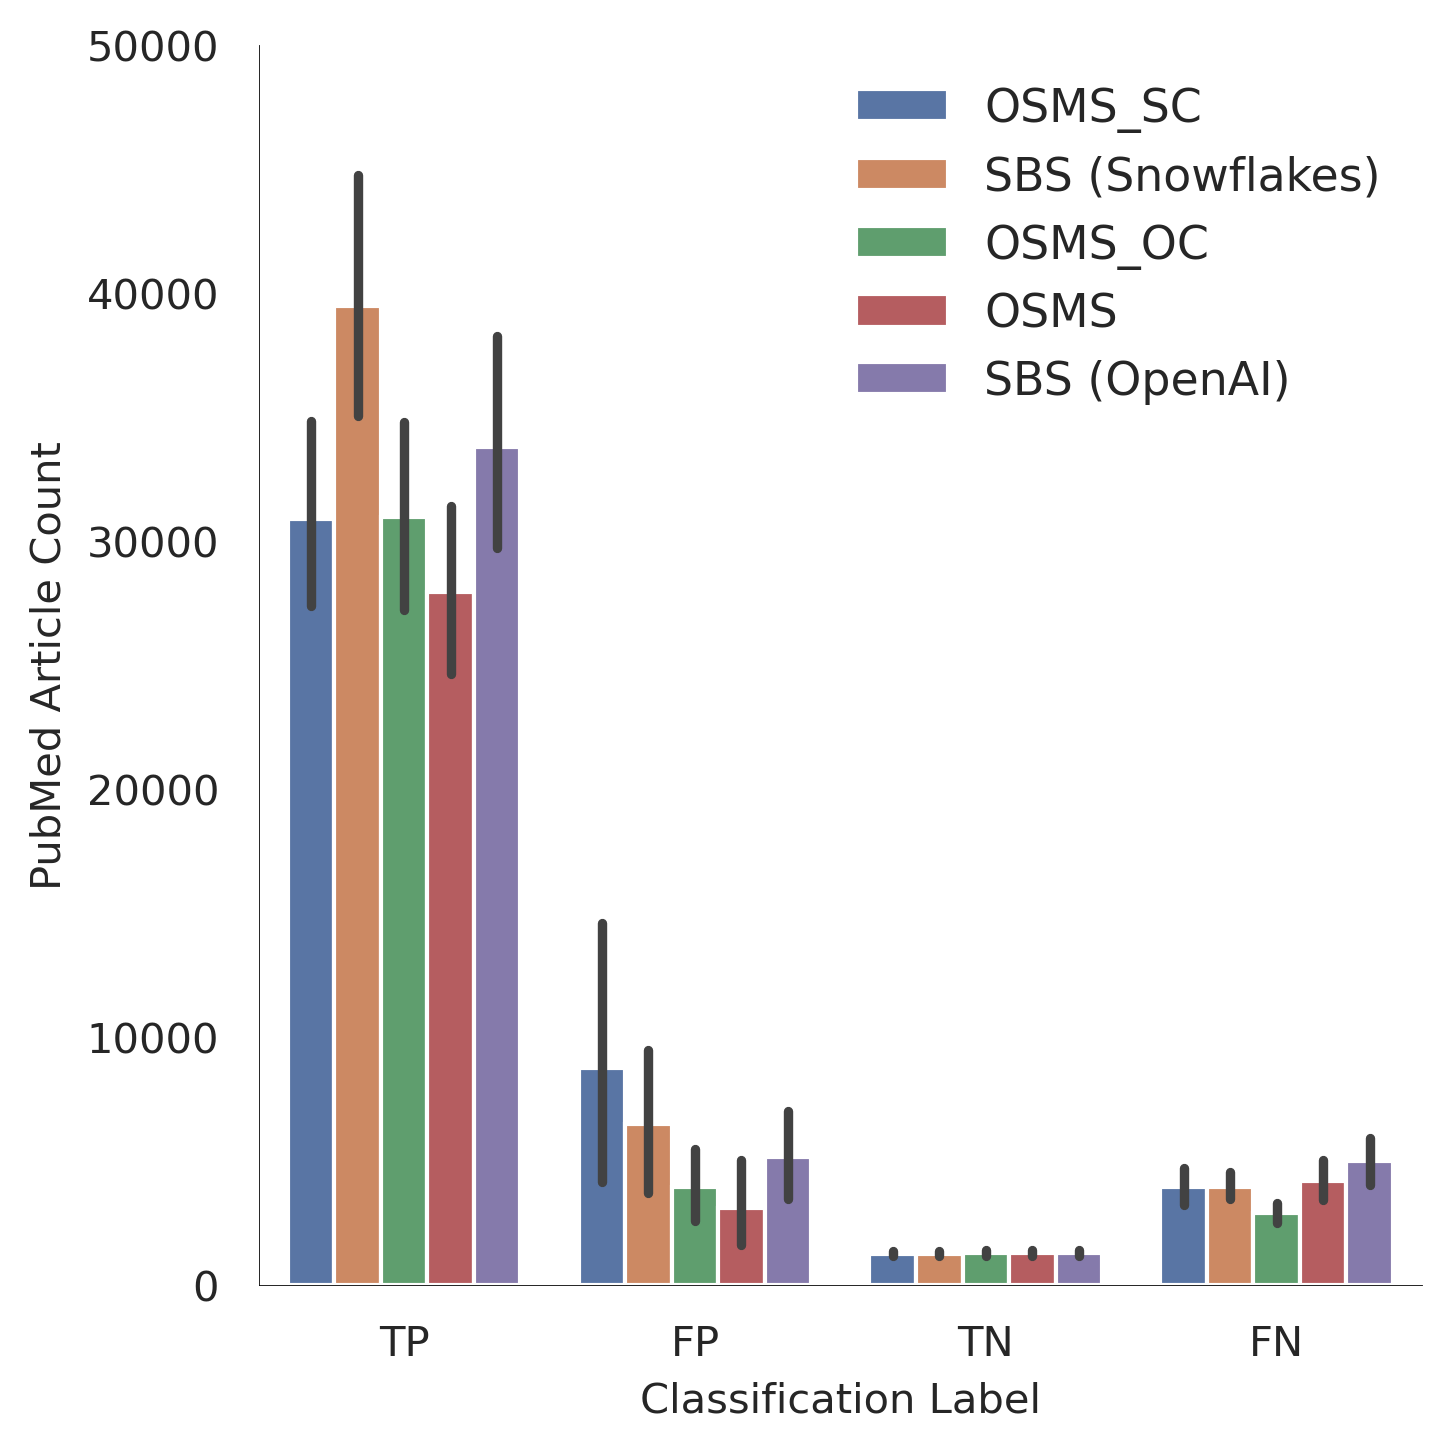

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

fig, ax = plt.subplots(figsize=(5, 5), dpi=300)

sns.barplot(
    data=complete_data_with_citation,
    x="label", 
    y="Pubmed Article Count", 
    hue="category", 
    ax=ax,
)

# ax.set_title("PubMed Articles by Label and Similarity Score", fontsize=14)
ax.set_xlabel("Classification Label", fontsize=10)
ax.set_ylabel("PubMed Article Count", fontsize=10)
ax.set_ylim(0, 50000)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')
# ax.set_yscale("log")
# Move legend outside the plot
# ax.legend(title="Similarity Score", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=8)
ax.legend(frameon=False)
ax = custom_figure_axis(ax, fontsize=10, show_ticks = True, rotation=0)
plt.tight_layout()
plt.show()


In [77]:
complete_data_with_citation.to_csv("semantic_simulation_result_with_citation.csv", index=False)

In [83]:
# sns.barplot(data=complete_data_with_citation,x="label", y="Pubmed Article Count", hue="similarity_score")

In [63]:
complete_data_with_citation[["category", "label", "Pubmed Article Count"]].groupby(["label", "category", ]).agg(["mean", "std"]).reset_index()


label          category Pubmed Article Count              
                                           mean           std
0     FN              OSMS          4180.132544  11868.431530
1     FN           OSMS_OC          2898.004069   6515.063780
2     FN           OSMS_SC          3933.991159  12585.610586
3     FN      SBS (OpenAI)          4981.724626  16907.953628
4     FN  SBS (Snowflakes)          3931.790087   9849.337290
5     FP              OSMS          3107.975000   5710.613697
6     FP           OSMS_OC          3959.745455   5488.016123
7     FP           OSMS_SC          8719.375000  16856.583387
8     FP      SBS (OpenAI)          5161.159091   6438.304207
9     FP  SBS (Snowflakes)          6473.913043   9878.837111
10    TN              OSMS          1274.270987   5982.151006
11    TN           OSMS_OC          1266.730122   5981.468734
12    TN           OSMS_SC          1257.586259   5901.553657
13    TN      SBS (OpenAI)          1264.375848   5974.536022
14    TN  SBS (Snowflakes)          1257.467322   5948.029522
15    TP              OSMS         27918.401220  69676.517995
16    TP           OSMS_OC         30938.516644  72461.862986
17    TP           OSMS_SC         30888.607362  72907.153184
18    TP      SBS (OpenAI)         33772.686672  76651.952777
19    TP  SBS (Snowflakes)         39464.486972  82023.236124

Across all classification categories, true positives (TP) exhibited the highest average citation count, with a mean of 32,094.75 (SD = 74,372.87). This was followed by false positives (FP), which had a mean citation count of 5,281.18 (SD = 9,282.11), and false negatives (FN), with a mean of 4,016.27 (SD = 12,153.20). True negatives (TN) consistently showed the lowest citation frequency, with a mean of 1,264.09 (SD = 5,957.37). These results suggest that semantically retrieved terms classified as TP tend to be more frequently co-cited in the literature compared to other categories.



In [66]:
complete_data_with_citation[["label", "Pubmed Article Count"]].groupby(["label"]).agg(["mean", "std"]).reset_index()


label Pubmed Article Count              
                        mean           std
0    FN          4016.273432  12153.197702
1    FP          5281.179724   9282.112410
2    TN          1264.085032   5957.371924
3    TP         32094.753462  74372.865501

In [78]:
complete_data_with_citation.to_excel("complete_data_with_citation.xlsx", index=False)

In [79]:
metric_df = pd.DataFrame(columns = ["precision", "recall", "f1",  "kappa", "element scanned", "time_consumed", "specificity"])
metric_df_full = pd.DataFrame(columns = ["precision", "recall", "f1",  "kappa", "element scanned", "time_consumed", "specificity"])



for i in set(full_df["term"]):
    
    for similarity_score, llm_model_for_element_selection in zip(similarity_score_method, llm_model_for_element_selection_list):
        counter = 0
        for j in range(iteration):

            tmp = full_df[(full_df["term"].isin([i])) & (full_df["similarity_score"].isin([similarity_score])) & (full_df["llm_model_for_element_selection"].isin([llm_model_for_element_selection])) & (full_df["iteration"].isin([j])) ]
            tmp.reset_index(inplace=True, drop=True)
            metric_df.loc[counter, "precision"] = precision_score(list(tmp["actual label"]), list(tmp["predicted label"]))
            metric_df.loc[counter, "recall"] = recall_score(list(tmp["actual label"]), list(tmp["predicted label"]))
            # metric_df.loc[i, "precision"] = precision_score(tmp_df["actual label"], tmp_df["predicted label"])
            metric_df.loc[counter, "f1"] = f1_score(list(tmp["actual label"]), list(tmp["predicted label"]))
            metric_df.loc[counter, "kappa"] = cohen_kappa_score(list(tmp["actual label"]), list(tmp["predicted label"]))
            metric_df.loc[counter, "iteration"] = j
            metric_df.loc[counter, "element scanned"] = tmp.loc[0, "element_scanned"]
            metric_df.loc[counter, "time_consumed"] = tmp.loc[0, "time_consumed"]
            metric_df.loc[counter, "term"] = i
            metric_df.loc[counter, "similarity_score"] = similarity_score
            # metric_df.loc[i, "similarity_score"] = similarity_score
            metric_df.loc[counter, "llm_model_for_element_selection"] = llm_model_for_element_selection
            metric_df.loc[counter, "specificity"] = specificity_score(list(tmp["actual label"]), list(tmp["predicted label"]))

            metric_df.loc[counter, "element scanned (%)"] = tmp.loc[0, "element_scanned"] / full_df[(full_df["similarity_score"].isin(["None"])) & (full_df["term"].isin([i]))]["element_scanned"][0].unique()[0]
            
        
            

            counter = counter + 1
        metric_df_full = pd.concat([metric_df_full, metric_df])
            
            

/home/abhishekh/anaconda3/envs/ttd2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/abhishekh/anaconda3/envs/ttd2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/abhishekh/anaconda3/envs/ttd2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

In [80]:
metric_df_full

,precision,recall,f1,kappa,element scanned,time_consumed,specificity,iteration,term,similarity_score,llm_model_for_element_selection,element scanned (%)
0,0.909091,0.208333,0.338983,0.287115,65.0,1.168686,0.994949,0.0,tyrosine kinase,snowflakes_cutoff,OpenAI,0.264228
1,1.0,0.208333,0.344828,0.297565,65.0,1.199821,1.0,1.0,tyrosine kinase,snowflakes_cutoff,OpenAI,0.264228
2,1.0,0.208333,0.344828,0.297565,65.0,1.228887,1.0,2.0,tyrosine kinase,snowflakes_cutoff,OpenAI,0.264228
3,0.909091,0.208333,0.338983,0.287115,65.0,1.096025,0.994949,3.0,tyrosine kinase,snowflakes_cutoff,OpenAI,0.264228
4,1.0,0.208333,0.344828,0.297565,65.0,1.042896,1.0,4.0,tyrosine kinase,snowflakes_cutoff,OpenAI,0.264228
...,...,...,...,...,...,...,...,...,...,...,...,...
0,1.0,0.52,0.684211,0.633913,53.0,7.852165,1.0,0.0,cardiovascular,OpenAI,OpenAI,0.212851
1,1.0,0.52,0.684211,0.633913,53.0,8.121919,1.0,1.0,cardiovascular,OpenAI,OpenAI,0.212851
2,1.0,0.52,0.684211,0.633913,53.0,8.370119,1.0,2.0,cardiovascular,OpenAI,OpenAI,0.212851
3,1.0,0.52,0.684211,0.633913,53.0,7.976398,1.0,3.0,cardiovascular,OpenAI,OpenAI,0.212851


In [81]:
def custom_figure_axis(ax, fontsize=10, show_ticks = True, rotation=90):
    
        
    """
    Customize the appearance of matplotlib axis for a figure.
    
    Parameters:
        ax (matplotlib.axes._subplots.AxesSubplot): The axis to be customized.
        fontsize (int, optional): Font size for axis labels and ticks. Default is 10.
        show_ticks (bool, optional): Whether to display ticks and labels. Default is True.
    
    Returns:
        matplotlib.axes._subplots.AxesSubplot: The customized axis.
    """
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['top'].set_color('white')
    ax.spines['right'].set_color('white')
    ax.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(0.2)
    ax.spines['left'].set_linewidth(0.2)
    ax.tick_params(axis='x', labelsize=fontsize, rotation=rotation)
    ax.tick_params(axis='y', labelsize=fontsize)
    ax.tick_params(axis='both', which='both', width=0.5)
    ax.xaxis.label.set_fontsize(fontsize)
    ax.yaxis.label.set_fontsize(fontsize)
    
    if show_ticks==False:
        ax.set_xlabel(None)
        ax.set_ylabel(None)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        
    return ax

In [82]:
metric_df_full["similarity_score"] = metric_df_full["similarity_score"].fillna("None")

In [83]:
def conditional_text_color(value, threshold=0.5):
    """
    Returns a contrasting text color based on the cell value.
    If value is above the threshold, use black; otherwise, use white.
    """
    return "white" if value > threshold else "black"

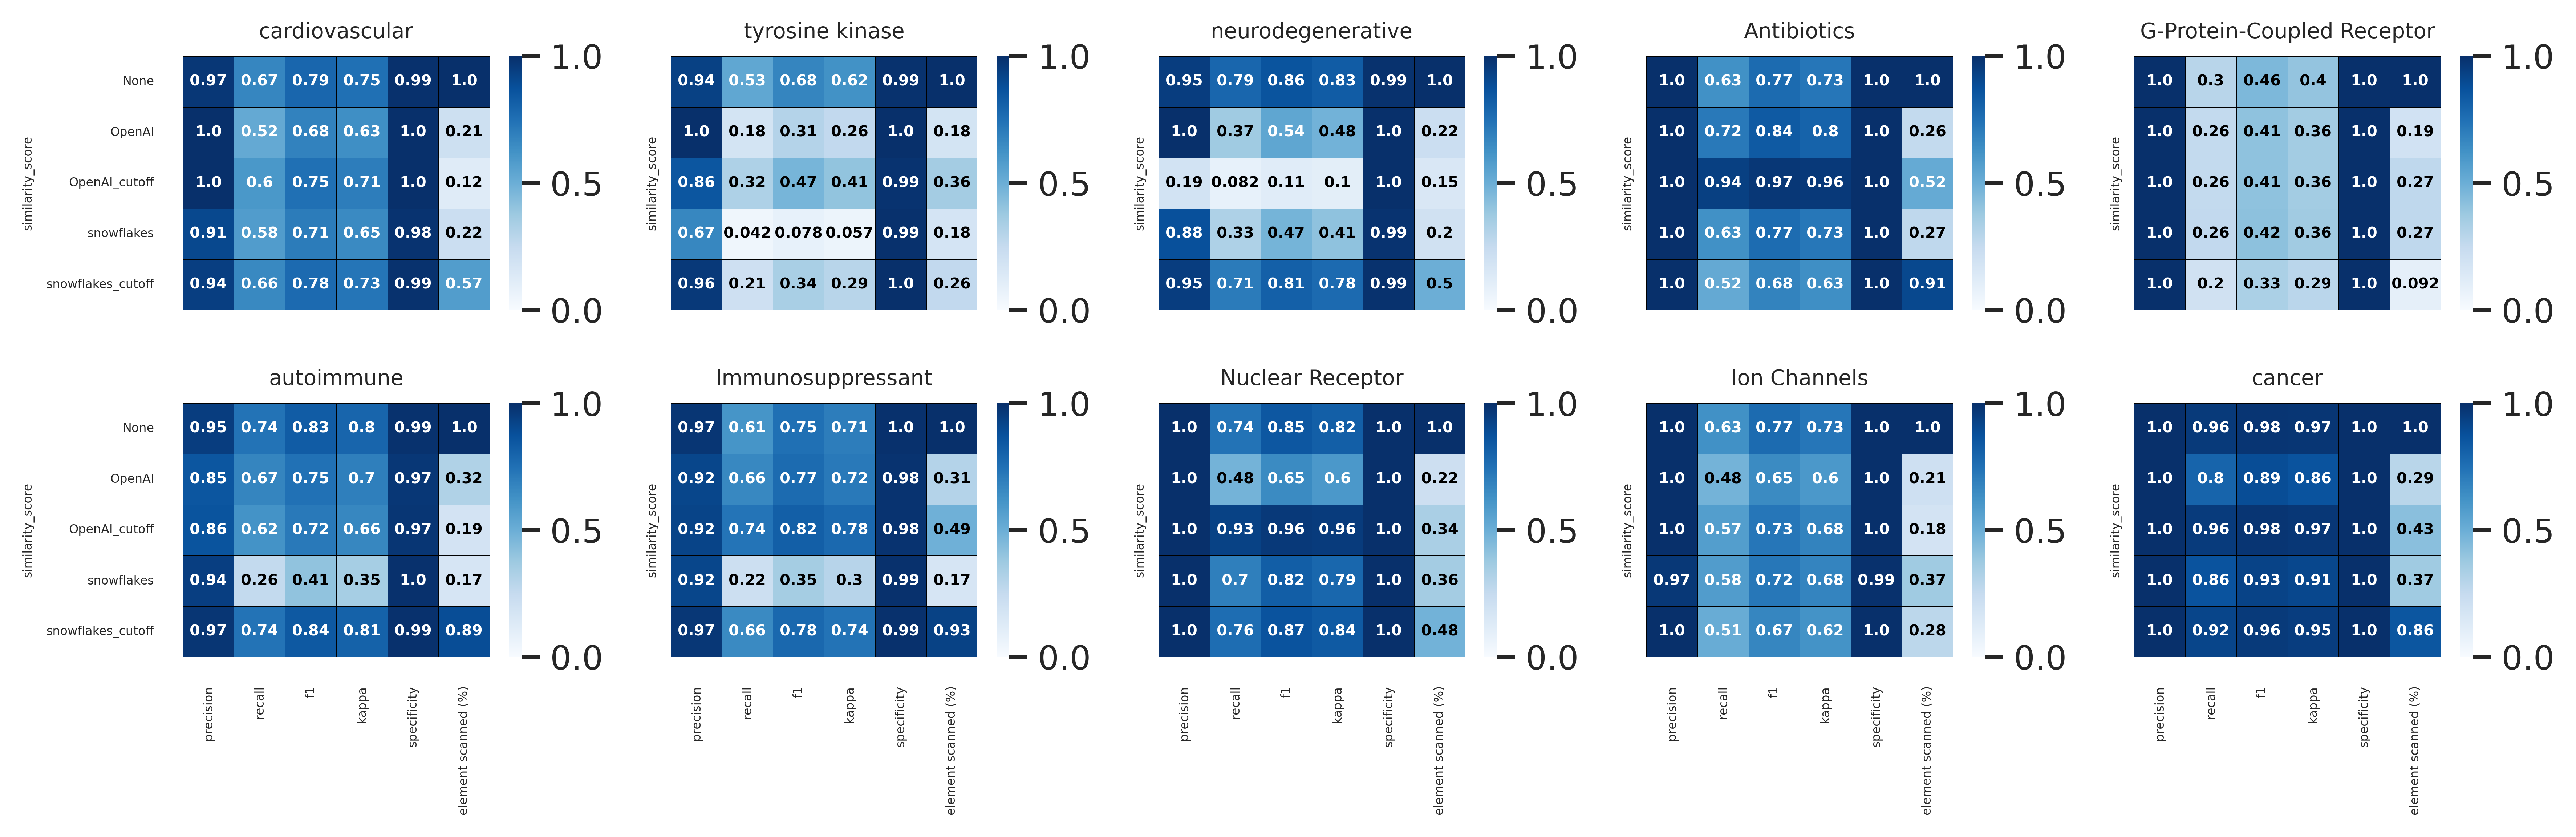

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 5, figsize =(12, 4), dpi = 600, sharey = True, sharex = True)

lst = list(set(metric_df_full["term"]))
counter = 0

for k in range(10):

    a = metric_df_full[metric_df_full.loc[:, "term"]==lst[counter]]

    b = a[['precision', 'recall', 'f1', 'kappa', "similarity_score", "specificity", "element scanned (%)", "term"]].groupby(["similarity_score", "term" ]).mean().reset_index()
    b.drop(["term"], axis=1, inplace=True)
    b.set_index(["similarity_score"], inplace=True)

    # # a = pd.to_numeric(a)
    b = b.apply(pd.to_numeric, errors='coerce')
    
    ax[int(counter/5)][int(counter%5)] = sns.heatmap(b, annot=True, ax= ax[int(counter/5)][int(counter%5)] , linecolor="black", linewidths=0.1, fmt="0.2", cmap='Blues', cbar=True, annot_kws={"size": 5, "color": "white", "weight": "bold"}, vmin=0, vmax=1)
    ax[int(counter/5)][int(counter%5)].set_title(lst[counter], fontsize=7)
    # ax[int(counter/5)][int(counter%5)].set_axis_off()
    ax[int(counter/5)][int(counter%5)] = custom_figure_axis(ax[int(counter/5)][int(counter%5)], fontsize=4, show_ticks = True, rotation=90)

    

    for text in ax[int(counter/5)][int(counter%5)].texts:
        # Get the value of the cell
        cell_value = float(text.get_text())
        # Set the color based on the conditional function
        text.set_color(conditional_text_color(cell_value, threshold=0.5))

    counter = counter + 1



plt.tight_layout()

plt.tight_layout()
# plt.savefig("heatmap_biochirp.pdf", dpi = 600)

In [20]:
# metric_df_full

In [85]:
metric_df_full[['precision', 'recall', 'f1', 'kappa', 'element scanned',
       'time_consumed', 'specificity', 'similarity_score', 'element scanned (%)']].groupby('similarity_score').agg(['mean', 'std'])

precision              recall                  f1            \
                       mean       std      mean       std      mean       std   
similarity_score                                                                
None               0.977701  0.032122  0.659717  0.169688  0.773997  0.133583   
OpenAI             0.977095  0.048554  0.514668  0.195787  0.648557  0.177375   
OpenAI_cutoff      0.883116  0.269993  0.602263  0.296152  0.692625  0.279947   
snowflakes         0.927437  0.100429   0.44602  0.249912  0.568053  0.252364   
snowflakes_cutoff  0.979651  0.026577  0.589062  0.227064  0.706693  0.204632   

                      kappa           element scanned             \
                       mean       std            mean        std   
similarity_score                                                   
None               0.735922  0.145634           248.0   1.749636   
OpenAI             0.602029  0.182476           59.72  11.930137   
OpenAI_cutoff      0.658864  0.285890            75.6  33.782618   
snowflakes         0.523371  0.255960           64.06  20.127563   
snowflakes_cutoff   0.66731  0.213439           143.1  72.401164   

                  time_consumed            specificity            \
                           mean        std        mean       std   
similarity_score                                                   
None                   4.535898   1.314927    0.995954  0.005773   
OpenAI                 8.546629   1.681104    0.995524  0.009696   
OpenAI_cutoff          4.864147   2.967414    0.994413  0.009174   
snowflakes            10.337913  12.767358    0.995356  0.005465   
snowflakes_cutoff      3.879067   1.704676    0.996762  0.004047   

                  element scanned (%)            
                                 mean       std  
similarity_score                                 
None                         1.000000  0.000000  
OpenAI                       0.240901  0.048697  
OpenAI_cutoff                0.305157  0.137047  
snowflakes                   0.257904  0.079821  
snowflakes_cutoff            0.577527  0.293060

In [86]:
complete_data_with_citation[['similarity_score', 'label', 'Pubmed Article Count']].groupby([ 'label','similarity_score']).agg(['mean', 'std', 'max'])

Pubmed Article Count                      
                                        mean           std     max
label similarity_score                                            
FN    None                       4180.132544  11868.431530  154762
      OpenAI                     4981.724626  16907.953628  189549
      OpenAI_cutoff              2898.004069   6515.063780   52480
      snowflakes                 3931.790087   9849.337290  189549
      snowflakes_cutoff          3933.991159  12585.610586  153807
FP    None                       3107.975000   5710.613697   19577
      OpenAI                     5161.159091   6438.304207   19577
      OpenAI_cutoff              3959.745455   5488.016123   19577
      snowflakes                 6473.913043   9878.837111   29002
      snowflakes_cutoff          8719.375000  16856.583387   47122
TN    None                       1274.270987   5982.151006  180469
      OpenAI                     1264.375848   5974.536022  180469
      OpenAI_cutoff              1266.730122   5981.468734  180469
      snowflakes                 1257.467322   5948.029522  180469
      snowflakes_cutoff          1257.586259   5901.553657  180469
TP    None                      27918.401220  69676.517995  551573
      OpenAI                    33772.686672  76651.952777  551573
      OpenAI_cutoff             30938.516644  72461.862986  551573
      snowflakes                39464.486972  82023.236124  551573
      snowflakes_cutoff         30888.607362  72907.153184  551573